In [12]:
#!/usr/bin/python

# Import required modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist, directed_hausdorff
from sklearn.svm import SVC
from sklearn.preprocessing import scale

# Import SOAP tools
import SOAPTools

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

# Function Definitions

In [13]:
def tabulate(predicted, true):
    """
        Tabulate the prediction accuracy of a classification,
        returning a matrix, e.g.,
        [[IZA predicted as IZA, IZA predicted as DEEM],
         [DEEM predicted as IZA, DEEM predicted as DEEM]]
         
         ---Arguments---
         predicted: predicted labels
         true: true labels
    """
    if len(predicted) != len(true):
        print('Label vectors must be same size!')
        return
    
    # Get unique categories
    names = np.unique(np.concatenate((predicted, true)))
    n_classes = names.size
    
    # Build (mis)classification matrix
    m = np.zeros((n_classes, n_classes))
    n = len(predicted)
    
    # (TODO: generalize this to more than 2
    # classes of arbitrary labels)
    # Build (mis)classification matrix
    for p, t in zip(predicted, true):
        if p == 'IZA' and t == 'IZA':
            m[0, 0] += 1
        elif p == 'DEEM' and t == 'DEEM':
            m[1, 1] += 1
        elif p == 'IZA' and t == 'DEEM':
            m[1, 0] += 1
        elif p == 'DEEM' and t == 'IZA':
            m[0, 1] += 1
    m /= n
    return n, m

def rand_idxs(n_IZA, n_DEEM, n_train, n_test):
    """
        Randomly select indices for testing and training
        
        ---Arguments---
        n_IZA: number of IZA samples
        n_DEEM: number of DEEM samples
        n_train: desired number of training structures
        n_test: desired number of test structures
    """
    
    # Indices correspond to size of data
    IZA_idxs = np.arange(0, n_IZA)
    DEEM_idxs = np.arange(0, n_DEEM)

    # Randomize the indices
    np.random.shuffle(IZA_idxs)
    np.random.shuffle(DEEM_idxs)

    # Select training and test sets from the
    # randomized indices.
    # Assume IZA is the 'limiting case', i.e.,
    # has fewer environments
    IZA_train = IZA_idxs[0:n_train]
    IZA_test = IZA_idxs[n_train:n_train+n_test]

    DEEM_train = DEEM_idxs[0:n_train]
    DEEM_test = DEEM_idxs[n_train:n_train+n_test]
    #DEEM_test = DEEM_idxs[n_train:]

    # An extra array of shuffled indices
    # that internally shuffle the train and test
    # sets after concatenation
    shuffle_train_idxs = np.arange(0, 2*n_train)
    shuffle_test_idxs = np.arange(0, 2*n_test)
    #shuffle_test_idxs = np.arange(0, n_DEEM-n_train+n_test)

    np.random.shuffle(shuffle_train_idxs)
    np.random.shuffle(shuffle_test_idxs)
    
    return IZA_train, IZA_test, \
        DEEM_train, DEEM_test, \
        shuffle_train_idxs, shuffle_test_idxs

def fps_unique(fps_file, prec=12, plot=False):
    """
        Takes a file with columns (indices, distances)
        from an FPS calculation and subselects
        based on the distance precision
        
        ---Arguments---
        fps_file: file from an FPS calculation with indices and distances
        prec: decimal precision; if an index corresponds to a distance of zero
              after rounding to prec decimal places, the environment
              is considered nonunique
        plot: make a semilog plot of the distances
    """
    
    # Load FPS data
    idxs, fps_distances = np.loadtxt(fps_file, unpack=True)
    
    # Number of nonzero distances
    n_nonzero = np.shape(fps_distances[fps_distances.round(prec) > 0])[0]
    
    print('Unique points with prec = %d: %d' % (prec, n_nonzero))
    
    # Indices of environments with nonzero corresponding distances
    idxs = idxs[fps_distances.round(prec) > 0].astype(np.int)
    fps_distances = fps_distances[fps_distances.round(prec) > 0]
    
    # Optional plotting
    if plot is True:
        fig = plt.figure(figsize=(3.5, 3.5))
        axs = fig.add_subplot(1, 1, 1)
        axs.semilogy(np.arange(0, fps_distances.shape[0]), fps_distances)
        axs.axvline(n_nonzero, color='r', linestyle='--')
        plt.show()
        
    return idxs#, fps_distances

def iza_deem_unique(deem, iza, metric='euclidean', prec=12):
    """
        Takes IZA and DEEM environments and removes the DEEM
        environments that are identical (to `prec` decimal places)
        to an IZA environment
        
        ---Arguments---
        iza: iza data where environments are rows and features are columns
        deem: deem data where environments are rows and features are columns
        metric: distance metric
        prec: decimal place precision for the distance comparison
    """
    
    # Compute distances between environments
    d = cdist(deem, iza, metric=metric)
    
    # Return only environments that have nonzero
    # corresponding distances
    idxs = np.any(d.round(prec) > 0.0, axis=1)
    return deem[idxs]

def cc(x, p):
    """
        Compute the Pearson correlation coefficient
        
        ---Arguments---
        x: feature data (e.g., SOAP KPCA)
        p: property data (e.g., decomposed volumes)
    """
    return np.dot(p-p.mean(), x-x.mean())/(np.std(p)*np.std(x)*len(p))

In [14]:
prec = 8

# KPCA Plots

Unique points with prec = 8: 68198


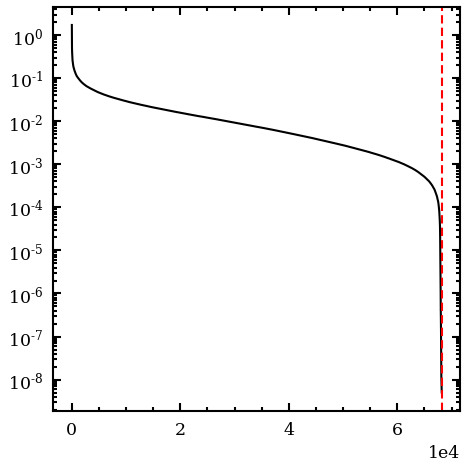

Building representative environments...
Unique points with prec = 8: 672


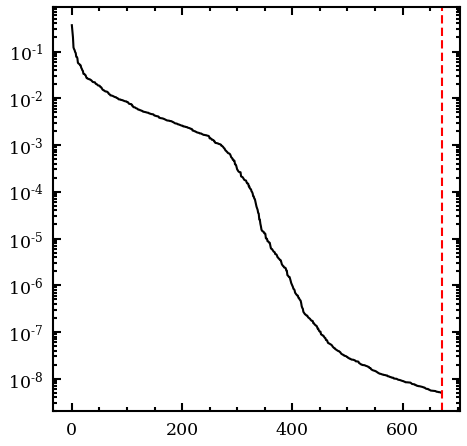

Building representative environments...


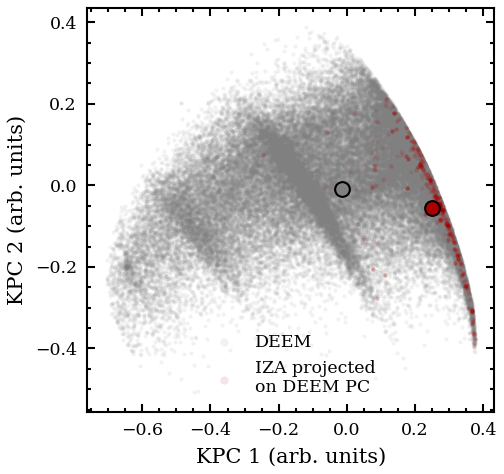

In [15]:
# Load PCA data for IZA and DEEM (3.5 A SOAP cutoff), keep unique environments
udxs_DEEM_KPCA_3 = fps_unique('../Processed_Data/DEEM_10k/PCA/3.5/FPS-uKPCA.idxs', prec=prec, plot=True)
inputDEEM = SOAPTools.read_input('../Processed_Data/DEEM_10k/PCA/3.5/KPCAFiles.dat')
DEEM_3 = SOAPTools.build_repSOAPs(inputDEEM, udxs_DEEM_KPCA_3)

udxs_IZA_KPCA_3 = fps_unique('../Processed_Data/IZAonDEEM_10k/PCA/3.5/FPS-uKPCA.idxs', prec=prec, plot=True)
inputIZA = SOAPTools.read_input('../Processed_Data/IZAonDEEM_10k/PCA/3.5/projFiles.dat')
IZA_3 = SOAPTools.build_repSOAPs(inputIZA, udxs_IZA_KPCA_3)

# Eliminate DEEM environments that are essentially IZA environments by proximity
#DEEM_3 = iza_deem_unique(DEEM_3, IZA_3, prec=prec)

### 2D PCA ###
# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot of IZA and DEEM
scatDEEM = axsScat.scatter(DEEM_3[:, 0], DEEM_3[:, 1], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.1)
scatIZA = axsScat.scatter(IZA_3[:, 0], IZA_3[:, 1], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.1)

meanDEEM_3 = np.mean(DEEM_3, axis=0)
meanIZA_3 = np.mean(IZA_3, axis=0)

axsScat.scatter(meanDEEM_3[0], meanDEEM_3[1], edgecolor='k', color=colorList[5], s=50)
axsScat.scatter(meanIZA_3[0], meanIZA_3[1], edgecolor='k', color=colorList[1], s=50)

# Axes labels and tick sizes
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

# Save figure
#figPCA.savefig('../Results/DEEM_1k/kpca_IZA_OPTonDEEM_3.5.png', bbox_inches='tight')

### 3D PCA ###
# Create figure
#fig3D = plt.figure(figsize=(7.0, 3.5))

# Create axes
#axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

# Scatter plot
#scatDEEM3D = axs3D.scatter(DEEM_3[:, 0], DEEM_3[:, 1], DEEM_3[:, 2], c=colorList[5], 
#                           edgecolor='k', linewidths=0.0, alpha=0.5)
#scatIZA3D = axs3D.scatter(IZA_3[:, 0], IZA_3[:, 1], IZA_3[:, 2], c=colorList[1], 
#                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and ticks
#axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
#axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
#axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
#axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
#axs3D.view_init(10, -120)

# Figure legend
#axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

#fig3D.savefig('../Results/DEEM_1k/kpca_IZA_OPTonDEEM_3.5_3D.png', bbox_inches='tight')

plt.show()

Unique points with prec = 8: 68201


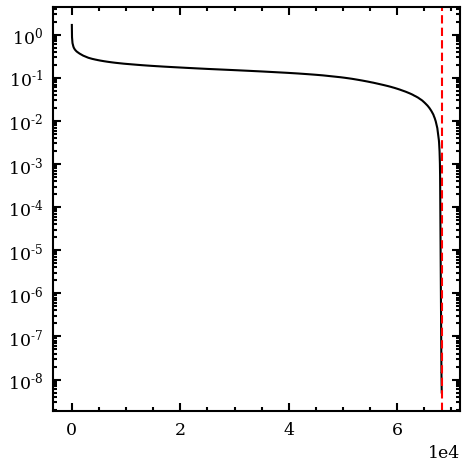

Building representative environments...
Unique points with prec = 8: 925


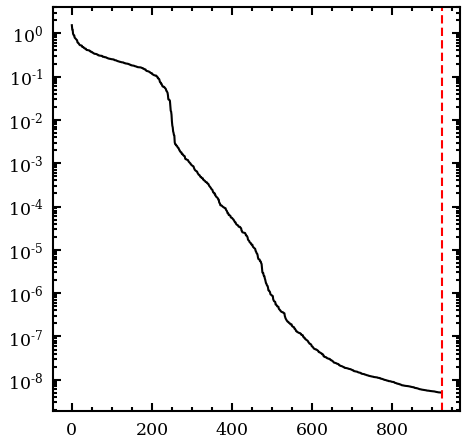

Building representative environments...


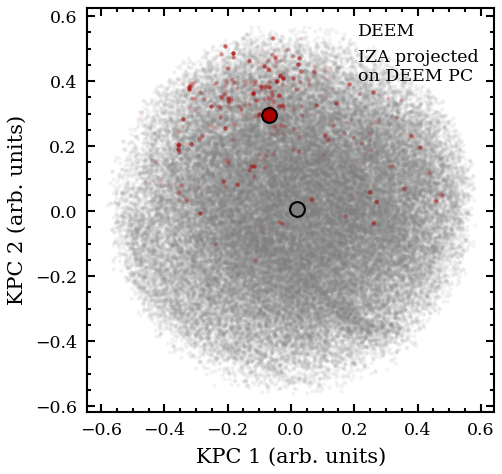

In [16]:
# Load PCA data for IZA and DEEM (3.5 A SOAP cutoff), keep unique environments
udxs_DEEM_KPCA_6 = fps_unique('../Processed_Data/DEEM_10k/PCA/6.0/FPS-uKPCA.idxs', prec=prec, plot=True)
inputDEEM = SOAPTools.read_input('../Processed_Data/DEEM_10k/PCA/6.0/KPCAFiles.dat')
DEEM_6 = SOAPTools.build_repSOAPs(inputDEEM, udxs_DEEM_KPCA_6)

udxs_IZA_KPCA_6 = fps_unique('../Processed_Data/IZAonDEEM_10k/PCA/6.0/FPS-uKPCA.idxs', prec=prec, plot=True)
inputIZA = SOAPTools.read_input('../Processed_Data/IZAonDEEM_10k/PCA/6.0/projFiles.dat')
IZA_6 = SOAPTools.build_repSOAPs(inputIZA, udxs_IZA_KPCA_6)

# Eliminate DEEM environments that are essentially IZA environments by proximity
#DEEM_6 = iza_deem_unique(DEEM_6, IZA_6, prec=prec)

### 2D PCA ###
# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot of IZA and DEEM
scatDEEM = axsScat.scatter(DEEM_6[:, 1], DEEM_6[:, 2], c=colorList[5], 
                           edgecolor='k', linewidths=0.0, alpha=0.1)
scatIZA = axsScat.scatter(IZA_6[:, 1], IZA_6[:, 2], c=colorList[1], 
                          edgecolor='k', linewidths=0.0, alpha=0.1)

meanDEEM_6 = np.mean(DEEM_6, axis=0)
meanIZA_6 = np.mean(IZA_6, axis=0)

axsScat.scatter(meanDEEM_6[1], meanDEEM_6[2], edgecolor='k', color=colorList[5], s=50)
axsScat.scatter(meanIZA_6[1], meanIZA_6[2], edgecolor='k', color=colorList[1], s=50)

# Axes labels and tick sizes
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

# Save figure
#figPCA.savefig('../Results/DEEM_1k/kpca_IZA_OPTonDEEM_3.5.png', bbox_inches='tight')

### 3D PCA ###
# Create figure
#fig3D = plt.figure(figsize=(7.0, 3.5))

# Create axes
#axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

# Scatter plot
#scatDEEM3D = axs3D.scatter(DEEM_6[:, 0], DEEM_6[:, 1], DEEM_6[:, 2], c=colorList[5], 
#                           edgecolor='k', linewidths=0.0, alpha=0.5)
#scatIZA3D = axs3D.scatter(IZA_6[:, 0], IZA_6[:, 1], IZA_6[:, 2], c=colorList[1], 
#                          edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and ticks
#axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
#axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
#axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
#axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
#axs3D.view_init(10, -120)

# Figure legend
#axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

#fig3D.savefig('../Results/DEEM_1k/kpca_IZA_OPTonDEEM_3.5_3D.png', bbox_inches='tight')

plt.show()

# Environment Properties

# SVM Classification

## 3.5

In [17]:
# Fraction of points to use for training
f_train = 0.8

# Set number of train and test samples
# assuming IZA will have fewer samples and
# using the same number of training and test
# samples for both IZA and DEEM_3;
# We do this independently for SOAP, PCA, and KPCA
# b/c they may not have the same number
# of unique environments
n_IZA_3 = IZA_3.shape[0]
n_DEEM_3 = DEEM_3.shape[0]
n_train_3 = int(f_train*n_IZA_3)
n_test_3 = n_IZA_3 - n_train_3

# Split into train and test sets
IZA_3_train, IZA_3_test, DEEM_3_train, DEEM_3_test, \
    shuffle_train_idxs_3, shuffle_test_idxs_3 = rand_idxs(n_IZA_3, n_DEEM_3, n_train_3, n_test_3)

train_3 = np.concatenate((IZA_3[IZA_3_train], DEEM_3[DEEM_3_train]))[shuffle_train_idxs_3]
test_3 = np.concatenate((IZA_3[IZA_3_test], DEEM_3[DEEM_3_test]))[shuffle_test_idxs_3]
u_3 = np.mean(train_3, axis=0)
s_3 = np.std(train_3, axis=0)
train_3 = (train_3 - u_3)/s_3
test_3 = (test_3 - u_3)/s_3
train_labels_3 = np.asarray(['IZA']*n_train_3 + ['DEEM']*n_train_3)[shuffle_train_idxs_3]
test_labels_3 = np.asarray(['IZA']*n_test_3 + ['DEEM']*n_test_3)[shuffle_test_idxs_3]

In [18]:
n_KPCA = 2
svc_3 = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_3.fit(train_3[:, 0:n_KPCA], train_labels_3)

# Mean accuracy
score_3 = svc_3.score(test_3[:, 0:n_KPCA], test_labels_3)

# Predicted labels
labels_3 = svc_3.predict(test_3[:, 0:n_KPCA])

# Build (mis)classification matrix
n_samples_3, m_3 = tabulate(labels_3, test_labels_3)
print("KPCA: ", score_3)
print(m_3)

KPCA:  0.8074074074074075
[[0.46296296 0.03703704]
 [0.15555556 0.34444444]]


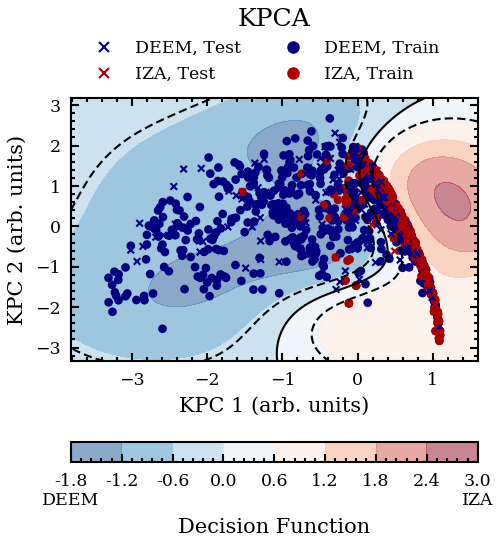

In [19]:
# Plot the SVM

# Create figure and axes
fig = plt.figure(figsize=(3.5, 3.5))
#axs_PCA = fig.add_subplot(1, 2, 1)
#axs_KPCA = fig.add_subplot(1, 2, 2)
axs = fig.add_subplot(1, 1, 1)

# Assign colors for the data points
#colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
#colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_3 = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_3]
colors_test_3 = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_3]

# Determine bounds for PCA decision function contour
#PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0])
#PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1])
#PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0])
#PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1])

# Build grid for PCA decision function
#PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
#                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

# Compute the PCA decision function
#df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
#df_PCA = np.reshape(df_PCA, PCA_xx.shape)

# Determine bounds for KPCA decision function contour
min_x = np.amin(np.concatenate((train_3, test_3))[:, 0])
min_y = np.amin(np.concatenate((train_3, test_3))[:, 1])
max_x = np.amax(np.concatenate((train_3, test_3))[:, 0])
max_y = np.amax(np.concatenate((train_3, test_3))[:, 1])

# Build grid for KPCA decision function
xx, yy = np.meshgrid(np.linspace(min_x-0.5, max_x+0.5, 100), np.linspace(min_y-0.5, max_y+0.5, 100))

# Compute the KPCA decision function
df_3 = svc_3.decision_function(np.column_stack((xx.ravel(), yy.ravel())))
df_3 = np.reshape(df_3, xx.shape)

# Plot decision functions and scatter plot
#contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
#axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
#axs_PCA.scatter(PCA_train[:, 0], PCA_train[:, 1], marker='o', c=colors_train_PCA[:], s=10)
#axs_PCA.scatter(PCA_test[:, 0], PCA_test[:, 1], marker='x', c=colors_test_PCA[:], s=10)

contour = axs.contourf(xx, yy, df_3, cmap='RdBu_r', alpha=0.5)
axs.contour(xx, yy, df_3, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs.scatter(train_3[:, 0], train_3[:, 1], marker='o', c=colors_train_3, s=10)
axs.scatter(test_3[:, 0], test_3[:, 1], marker='x', c=colors_test_3, s=10)

# Axes labels
#axs_PCA.set_xlabel('PC 1 (arb. units)')
#axs_PCA.set_ylabel('PC 2 (arb. units)')

axs.set_xlabel('KPC 1 (arb. units)')
axs.set_ylabel('KPC 2 (arb. units)')

# Custom legend entries
xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

# Custom legend
#axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
#               bbox_to_anchor=(0.0, 1.0), ncol=2)
axs.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
               bbox_to_anchor=(0.0, 1.0), ncol=2)

# Axes titles
#axs_PCA.set_title('PCA', pad=35)
axs.set_title('KPCA', pad=35)

# Colorbars for decision function with custom tick labels
#cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
#                      pad=0.2, label='Decision Function')
cb = fig.colorbar(contour, ax=axs, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

#cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
#cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
#cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
#cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_ticks = ['%.1f' % i for i in cb.get_ticks()]
cb_ticks[0] = cb_ticks[0] + '\nDEEM'
cb_ticks[-1] = cb_ticks[-1] + '\nIZA'
cb.set_ticklabels(cb_ticks)

#fig.subplots_adjust(wspace=0.25)

#fig.savefig('../Results/DEEM_1k/svm_IZA_OPTonDEEM_3.5.png', bbox_inches='tight')

plt.show()

## 6.0

In [20]:
# Fraction of points to use for training
f_train = 0.8

# Set number of train and test samples
# assuming IZA will have fewer samples and
# using the same number of training and test
# samples for both IZA and DEEM_6;
# We do this independently for SOAP, PCA, and KPCA
# b/c they may not have the same number
# of unique environments
n_IZA_6 = IZA_6.shape[0]
n_DEEM_6 = DEEM_6.shape[0]
n_train_6 = int(f_train*n_IZA_6)
n_test_6 = n_IZA_6 - n_train_6

# Split into train and test sets
IZA_6_train, IZA_6_test, DEEM_6_train, DEEM_6_test, \
    shuffle_train_idxs_6, shuffle_test_idxs_6 = rand_idxs(n_IZA_6, n_DEEM_6, n_train_6, n_test_6)

train_6 = np.concatenate((IZA_6[IZA_6_train], DEEM_6[DEEM_6_train]))[shuffle_train_idxs_6]
test_6 = np.concatenate((IZA_6[IZA_6_test], DEEM_6[DEEM_6_test]))[shuffle_test_idxs_6]
u_6 = np.mean(train_6, axis=0)
s_6 = np.std(train_6, axis=0)
train_6 = (train_6 - u_6)/s_6
test_6 = (test_6 - u_6)/s_6
train_labels_6 = np.asarray(['IZA']*n_train_6 + ['DEEM']*n_train_6)[shuffle_train_idxs_6]
test_labels_6 = np.asarray(['IZA']*n_test_6 + ['DEEM']*n_test_6)[shuffle_test_idxs_6]

In [21]:
n_start = 1
n_KPCA = 2
svc_6 = SVC(C=1.0, kernel='rbf', gamma='auto', decision_function_shape='ovr')
svc_6.fit(train_6[:, n_start:n_start+n_KPCA], train_labels_6)

# Mean accuracy
score_6 = svc_6.score(test_6[:, n_start:n_start+n_KPCA], test_labels_6)

# Predicted labels
labels_6 = svc_6.predict(test_6[:, n_start:n_start+n_KPCA])

# Build (mis)classification matrix
n_samples_6, m_6 = tabulate(labels_6, test_labels_6)
print("KPCA: ", score_6)
print(m_6)

KPCA:  0.7837837837837838
[[0.3972973  0.1027027 ]
 [0.11351351 0.38648649]]


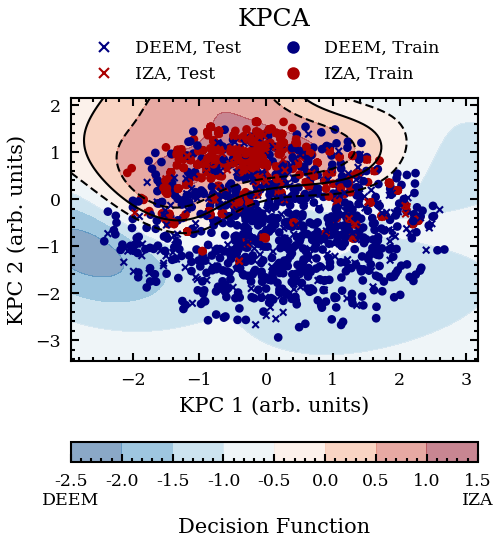

In [23]:
# Plot the SVM

# Create figure and axes
fig = plt.figure(figsize=(3.5, 3.5))
#axs_PCA = fig.add_subplot(1, 2, 1)
#axs_KPCA = fig.add_subplot(1, 2, 2)
axs = fig.add_subplot(1, 1, 1)

# Assign colors for the data points
#colors_train_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_PCA]
#colors_test_PCA = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_PCA]

colors_train_6 = [colorList[1] if x == 'IZA' else colorList[2] for x in train_labels_6]
colors_test_6 = [colorList[1] if x == 'IZA' else colorList[2] for x in test_labels_6]

# Determine bounds for PCA decision function contour
#PCA_min_x = np.amin(np.concatenate((PCA_train, PCA_test))[:, 0])
#PCA_min_y = np.amin(np.concatenate((PCA_train, PCA_test))[:, 1])
#PCA_max_x = np.amax(np.concatenate((PCA_train, PCA_test))[:, 0])
#PCA_max_y = np.amax(np.concatenate((PCA_train, PCA_test))[:, 1])

# Build grid for PCA decision function
#PCA_xx, PCA_yy = np.meshgrid(np.linspace(PCA_min_x-0.5, PCA_max_x+0.5, 100),
#                             np.linspace(PCA_min_y-0.5, PCA_max_y+0.5, 100))

# Compute the PCA decision function
#df_PCA = svc_PCA.decision_function(np.column_stack((PCA_xx.ravel(), PCA_yy.ravel())))
#df_PCA = np.reshape(df_PCA, PCA_xx.shape)

# Determine bounds for KPCA decision function contour
min_x = np.amin(np.concatenate((train_6, test_6))[:, n_start])
min_y = np.amin(np.concatenate((train_6, test_6))[:, n_start+1])
max_x = np.amax(np.concatenate((train_6, test_6))[:, n_start])
max_y = np.amax(np.concatenate((train_6, test_6))[:, n_start+1])

# Build grid for KPCA decision function
xx, yy = np.meshgrid(np.linspace(min_x-0.5, max_x+0.5, 100), np.linspace(min_y-0.5, max_y+0.5, 100))

# Compute the KPCA decision function
df_6 = svc_6.decision_function(np.column_stack((xx.ravel(), yy.ravel())))
df_6 = np.reshape(df_6, xx.shape)

# Plot decision functions and scatter plot
#contour_PCA = axs_PCA.contourf(PCA_xx, PCA_yy, df_PCA, cmap='RdBu_r', alpha=0.5)
#axs_PCA.contour(PCA_xx, PCA_yy, df_PCA, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
#axs_PCA.scatter(PCA_train[:, 0], PCA_train[:, 1], marker='o', c=colors_train_PCA[:], s=10)
#axs_PCA.scatter(PCA_test[:, 0], PCA_test[:, 1], marker='x', c=colors_test_PCA[:], s=10)

contour = axs.contourf(xx, yy, df_6, cmap='RdBu_r', alpha=0.5)
axs.contour(xx, yy, df_6, colors='k', levels=(-0.5, 0.0, 0.5), linestyles=('--', '-', '--'))
axs.scatter(train_6[:, n_start], train_6[:, n_start+1], marker='o', c=colors_train_6, s=10)
axs.scatter(test_6[:, n_start], test_6[:, n_start+1], marker='x', c=colors_test_6, s=10)

# Axes labels
#axs_PCA.set_xlabel('PC 1 (arb. units)')
#axs_PCA.set_ylabel('PC 2 (arb. units)')

axs.set_xlabel('KPC 1 (arb. units)')
axs.set_ylabel('KPC 2 (arb. units)')

# Custom legend entries
xblue = mpllines.Line2D([], [], color=colorList[2], marker='x', 
                        markersize=5, linestyle='None', label='DEEM, Test')
oblue = mpllines.Line2D([], [], color=colorList[2], marker='o', 
                        markersize=5, linestyle='None', label='DEEM, Train')
xred = mpllines.Line2D([], [], color=colorList[1], marker='x',
                      markersize=5, linestyle='None', label='IZA, Test')
ored = mpllines.Line2D([], [], color=colorList[1], marker='o',
                      markersize=5, linestyle='None', label='IZA, Train')

# Custom legend
#axs_PCA.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
#               bbox_to_anchor=(0.0, 1.0), ncol=2)
axs.legend(handles=(xblue, xred, oblue, ored), loc='lower left', 
               bbox_to_anchor=(0.0, 1.0), ncol=2)

# Axes titles
#axs_PCA.set_title('PCA', pad=65)
axs.set_title('KPCA', pad=35)

# Colorbars for decision function with custom tick labels
#cb_PCA = fig.colorbar(contour_PCA, ax=axs_PCA, orientation='horizontal', 
#                      pad=0.2, label='Decision Function')
cb = fig.colorbar(contour, ax=axs, orientation='horizontal', 
                      pad=0.2, label='Decision Function')

#cb_PCA_ticks = ['%.1f' % i for i in cb_PCA.get_ticks()]
#cb_PCA_ticks[0] = cb_PCA_ticks[0] + '\nDEEM'
#cb_PCA_ticks[-1] = cb_PCA_ticks[-1] + '\nIZA'
#cb_PCA.set_ticklabels(cb_PCA_ticks)

cb_ticks = ['%.1f' % i for i in cb.get_ticks()]
cb_ticks[0] = cb_ticks[0] + '\nDEEM'
cb_ticks[-1] = cb_ticks[-1] + '\nIZA'
cb.set_ticklabels(cb_ticks)

#fig.subplots_adjust(wspace=0.25)

#fig.savefig('../Results/DEEM_1k/svm_IZA_OPTonDEEM_6.5.png', bbox_inches='tight')

plt.show()